In [87]:
import numpy as np
from helpers import get_dff_fat
from constants_v1 import *

# Data frames
import pandas as pd
from helpers_pd import *
pd.options.mode.chained_assignment = None  # default='warn'

# Plotting
import seaborn as sns
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

## Selecting data frames to plot

### Steps

We want to selct only 4 time series of extremes, one max and one min for each model version at a given constraint.  

- Select constraint conditions
- Get min/max DT50 value (i.e. to select the correct time series to plot).
- Get the 4 associated time series, assigne column name, e.g. "DegVar_DT50min", etc.
- Repeat for Degradation, Persistence, Leaching (as percent of degradation)
- Get any time series for total applied, make it cumulative
- Merge all TSS, compute each column as percentage


In [88]:
df = get_dff_fat(new=False, copy=True)
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']

In [89]:
dfs = df[['Model',
          'dt_50_ref',
          'k_d',
          'epsilon_iso',
          'KGE-CONC-tra',
          'KGE-d13C-tra'
          ]]

In [113]:
ff = dfs.loc[(dfs['KGE-CONC-tra'] > 0.6) & (dfs['k_d'] < 100)]
ff_c = ff.loc[(ff['KGE-d13C-tra'] > 0.8)]
dflist = [ff, ff_c]
print(len(ff), len(ff_c))
ff.head()

(105, 12)


,Model,dt_50_ref,k_d,epsilon_iso,KGE-CONC-tra,KGE-d13C-tra
LHS_be1fix3/119/,fix,11.603791,6.305324,2.122900,0.650139,0.302644
LHS_be1fix3/128/,fix,14.321159,53.882385,4.445482,0.640758,-1.057900
LHS_be1fix3/147/,fix,12.651299,74.897479,3.585990,0.661330,-0.711955
LHS_be1fix3/164/,fix,15.617104,7.975010,4.764859,0.615686,-1.065864
LHS_be1fix3/2/,fix,14.231304,76.784047,4.561510,0.636017,-1.172821


## Variable TSS

In [114]:
# DF1
ff_var = ff[ff['Model'] == 'var']
var_max = ff_var['dt_50_ref'].max()
var_min = ff_var['dt_50_ref'].min()
print(var_min, var_max)

# DF2, Constrained model
ff_var_c = ff_c[ff_c['Model'] == 'var']
var_maxc = ff_var_c['dt_50_ref'].max()
var_minc = ff_var_c['dt_50_ref'].min()

print(var_minc, var_maxc)

(10.77138626142473, 39.663271172617975)
(10.77138626142473, 31.676136493699218)


In [115]:
# Get paths and their min, max values
# var_paths = []
# var_pvals = []

# for df in dflist:
#     val = df['dt_50_ref'][(df['Model'] == 'var')].min()
#     mIndex = df.index[(ff['Model'] == 'var') & (ff['dt_50_ref'] == var_min)].tolist()[0]
#     var_paths.append(index)

var_paths = [
    ff.index[(ff['Model'] == 'var') & (ff['dt_50_ref'] == var_min)].tolist()[0],
    ff.index[(ff['Model'] == 'var') & (ff['dt_50_ref'] == var_max)].tolist()[0],
    ff_c.index[(ff_c['Model'] == 'var') & (ff_c['dt_50_ref'] == var_minc)].tolist()[0],
    ff_c.index[(ff_c['Model'] == 'var') & (ff_c['dt_50_ref'] == var_maxc)].tolist()[0]
]

var_pvals = [
    ff['dt_50_ref'][(ff['Model'] == 'var')].min(),
    ff['dt_50_ref'][(ff['Model'] == 'var')].max(),
    ff_c['dt_50_ref'][(ff_c['Model'] == 'var')].min(),
    ff_c['dt_50_ref'][(ff_c['Model'] == 'var')].max()
]

df_types = [
    'vNC', # no constraint
    'vNC',
    'vWC', # with constraint
    'vWC'
]

print(var_paths[0], var_paths[1])
print(var_pvals[0], var_pvals[1])
print(var_paths[2], var_paths[3])
print(var_pvals[2], var_pvals[3])

('LHS_s2var5/11/', 'LHS_gu1var5/2/')
(10.77138626142473, 39.663271172617975)
('LHS_s2var5/11/', 'LHS_be1var1/100/')
(10.77138626142473, 31.676136493699218)


### Get cumulative applied mass (grams)

All data frames have this time series, and does not change (inefficiency yes)

In [116]:
path = var_paths[0]
app = pd.read_table(path + "resM_accAPP.tss", 
                   skiprows=4, delim_whitespace=True,
                                names=['Jdays', 'app'],
                                header=None)
# time = app['Jdays']
app['Capp'] = app['app'].cumsum()
# app.head()

### Get simulated 

In [117]:
filename = "resM_accDEGz0.tss"
vname = filename[-9:-6]
print(vname)

sets = []
for i in range(len(var_paths)):
    # Define variable name
    series_name = vname + '.' + str(int(var_pvals[i])) + df_types[i]
    # Get sim TSS
    sim = pd.read_table(var_paths[i] + filename, 
                   skiprows=4, delim_whitespace=True,
                                names=['Jdays', series_name],
                                header=None
                  )
    # Cumalte mass degraded
    sim['Cdeg'] = sim[series_name].cumsum()
    
    # Calculate percentage, retain.
    sim = pd.merge(app, sim, how='inner', on='Jdays')
    sim[series_name] = 100*(sim['Cdeg']/sim['Capp'])
    sim = sim[['Jdays', series_name]]
    sets.append(sim)
    
sdf = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)

sdf.head(20)

DEG


,Jdays,DEG.10vNC,DEG.39vNC,DEG.10vWC,DEG.31vWC
0,166,inf,inf,inf,inf
1,167,inf,inf,inf,inf
2,168,inf,inf,inf,inf
3,169,inf,inf,inf,inf
4,170,inf,inf,inf,inf
5,171,8.455668,2.880893,8.455668,3.811302
6,172,15.832278,5.528028,15.832278,7.275256
7,173,22.409434,8.013140,22.409434,10.495026
8,174,28.190986,10.301416,28.190986,13.429030
9,175,33.552269,12.563352,33.552269,16.316630


In [118]:
import numpy as np; np.random.seed(3)
import pandas as pd
import seaborn.apionly as sns
import matplotlib.pyplot as plt

In [119]:
time = np.asarray(sdf['Jdays'])
ncMin = np.asarray(sdf.iloc[:, 1:2])[:,0]
# ncMin = sdf.iloc[:, 1:2]
ncMax = np.asarray(sdf.iloc[:, 2:3])[:,0]
wcMin = np.asarray(sdf.iloc[:, 3:4])[:,0]
wcMax = np.asarray(sdf.iloc[:, 4:5])[:,0]

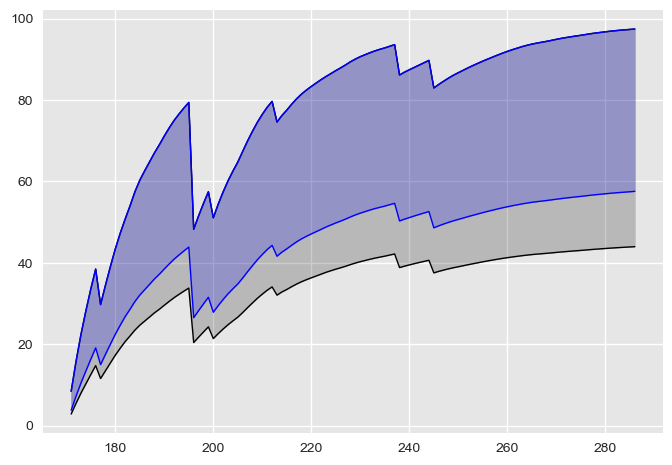

In [120]:
sns.set() # For background
sns.set_style("darkgrid", {"axes.facecolor": ".9"})


plt.plot(time,ncMin,lw=1, color='k')
plt.plot(time,ncMax,lw=1, color='k')

plt.plot(time,wcMin,lw=1, color='b')
plt.plot(time,wcMax,lw=1, color='b')


plt.fill_between(time,ncMin,ncMax,color='k',alpha=.2)
plt.fill_between(time,wcMin,wcMax,color='b',alpha=.2) # Blue is constrained
plt.show()

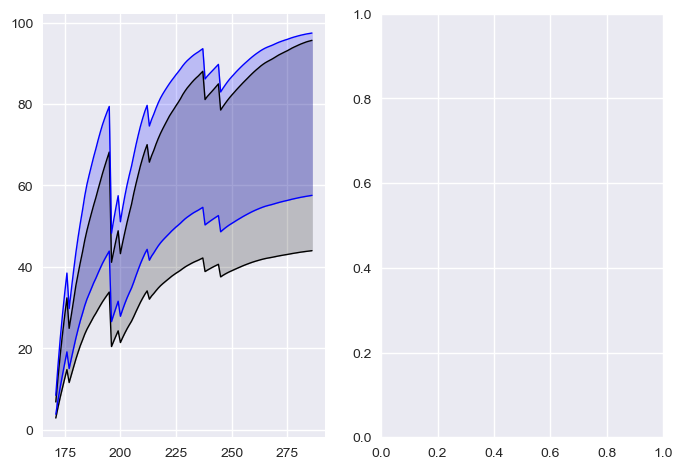

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False)

ax1.plot(time,ncMin,lw=1, color='k')
ax1.plot(time,ncMax,lw=1, color='k')

ax1.plot(time,wcMin,lw=1, color='b')
ax1.plot(time,wcMax,lw=1, color='b')

ax1.fill_between(time,ncMin,ncMax,color='k',alpha=.2)
ax1.fill_between(time,wcMin,wcMax,color='b',alpha=.2)

# ax1 = sns.lineplot(x="Jdays", y=list(ncMin)[0], data=ncMin)
# ax1.fill_between(time, ncMax, ncMin)
plt.show()

## Options

        {'axes.axisbelow': True,
         'axes.edgecolor': '.8',
         'axes.facecolor': 'white',
         'axes.grid': True,
         'axes.labelcolor': '.15',
         'axes.spines.bottom': True,
         'axes.spines.left': True,
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'font.family': ['sans-serif'],
         'font.sans-serif': ['Arial',
          'DejaVu Sans',
          'Liberation Sans',
          'Bitstream Vera Sans',
          'sans-serif'],
         'grid.color': '.8',
         'grid.linestyle': '-',
         'image.cmap': 'rocket',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'w',
         'patch.force_edgecolor': True,
         'text.color': '.15',
         'xtick.bottom': False,
         'xtick.color': '.15',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': '.15',
         'ytick.direction': 'out',
         'ytick.left': False,
         'ytick.right': False}

In [ ]:
def get_data(n=266, s=[5,13]):
    val = np.c_[np.random.poisson(lam=s[0], size=n),
                np.random.poisson(lam=s[1], size=n)].T.flatten()
    comp = [s[0]]*n +  [s[1]]*n
    ov = np.random.choice(list("ABC"), size=2*n)
    return pd.DataFrame({"val":val, "overlap":ov, "comp":comp})

data1 = get_data(s=[9,11])
data2 = get_data(s=[7,19])
data3 = get_data(s=[1,27])

#option2 plot each subplot individually
data = [data1,data2,data3]
bw = 2


In [ ]:
fig, axes = plt.subplots(3,3, sharex=True, sharey=True)
for i in range(3):
    for j in range(3):
        x = data[i]
        x = x[x["overlap"] == x["overlap"].unique()[j]]
        for hue in x["comp"].unique():
            d = x[x["comp"] == hue]
            sns.kdeplot(d["val"], ax=axes[i,j], bw=bw, label=hue )

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0.0, 2, 0.01)
y1 = np.sin(2*np.pi*x)
y2 = 1.2*np.sin(4*np.pi*x)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.fill_between(x, 0, y1)
ax1.set_ylabel('between y1 and 0')

ax2.fill_between(x, y1, 1)
ax2.set_ylabel('between y1 and 1')

ax3.fill_between(x, y1, y2)
ax3.set_ylabel('between y1 and y2')
ax3.set_xlabel('x')

plt.show()

In [ ]:
X  = np.linspace(0,3,200)
Y1 = X**2 + 3
Y2 = np.exp(X) + 2
Y3 = np.cos(X)

plt.plot(X,Y1,lw=4)
plt.plot(X,Y2,lw=4)
plt.plot(X,Y3,lw=4)

# plt.fill_between(X, Y2,Y3,color='k',alpha=.5)
plt.fill_between(X, Y1,Y2,color='k',alpha=.5)
plt.fill_between(X, Y1,Y3,color='y',alpha=.5)
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

x = [1.883830, 7.692308,8.791209, 9.262166]
y = [5.337520, 4.866562, 2.825746, 6.122449]
ax = sns.distplot(x, fit_kws={"color":"red"}, kde=False,
        fit=stats.gamma, hist=None, label="label 1");
ax = sns.distplot(y, fit_kws={"color":"blue"}, kde=False,
        fit=stats.gamma, hist=None, label="label 2");

# Get the two lines from the axes to generate shading
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
x1 = l1.get_xydata()[:,0]
y1 = l1.get_xydata()[:,1]
x2 = l2.get_xydata()[:,0]
y2 = l2.get_xydata()[:,1]
ax.fill_between(x1,y1, color="red", alpha=0.3)
ax.fill_between(x2,y2, color="blue", alpha=0.3)

plt.show(block=False)

In [24]:
sns.set(style="darkgrid")

# Load an example dataset with long-form data
fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
sns.lineplot(x="timepoint", y="signal",
             hue="region", style="event",
             data=fmri)

AttributeError: 'module' object has no attribute 'lineplot'